In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab06_community_detection.ipynb")

In [2]:
!pip install --upgrade networkx==3.1
import networkx as nx
%matplotlib inline

  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.imagesource {
    font-size: xx-small;
}
</style>
""")

from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

import os
import networkx as nx
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Lab 6: Community detection

In this lab, we will explore some community detection algorithms, looking at one divisive algorithm (Girvan and Newman) in detail. Then, we will apply community detection algorithms to a real-world social network in the Indian Village Network dataset.

## Shortest Paths and Edge Betweenness Centrality

Let's first create a simple social network with 15 nodes:

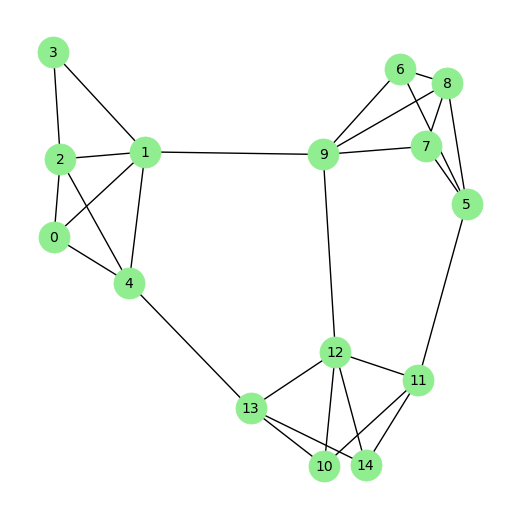

In [4]:
edges = [(0, 1), (0, 2),  (0, 4), (1, 2), (1, 3), (1, 4), (1, 9), 
            (2, 3), (2, 4), (4, 13), (5, 6), (5, 7), (5, 8),  
            (5, 11), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9), (9, 12), 
            (10, 11), (10, 12), (10, 13), (11, 12), (11, 14), 
            (12, 13), (12, 14), (13, 14)]

g1 = nx.Graph()
g1.add_edges_from(edges)

plt.figure(figsize=(5, 5))
nx.draw(g1, with_labels=True, node_color='lightgreen', edge_color='black', node_size=500, font_size=10)
plt.show()

<!-- BEGIN QUESTION -->

## Question 1

Through eyeballing the plot above, how many cliques/communities do you think there are in the network we just created? Which edges are 'bridges' that connect different cliques?

<!-- END QUESTION -->

If we want to detect communities divisively, that is, by removing edges from the network, we should first remove the 'bridges' that connect different communities. In order to do that, we need a measure for how 'bridging' or 'in-between' different nodes an edge is. Girvan and Newman called this measure **edge betweenness centrality**: 
$$bc(e) = \sum_{s, t \in V} \frac{\sigma_{s, t | e}}{\sigma_{s, t}}$$

where $bc(e)$ is the betweenness centrality of edge $e$,

$\sigma(s, t)$ is the number of shortest paths between node $s$ and node $t$,

and $\sigma_{s, t | e}$ is the number of the shortest paths between node $s$ and node $t$ that goes through edge $e$.

Let's first see how to calculate shortest paths. In networkx, the method shortest_path(graph, source, target) calculates the shortest path between a source node and a target node. As an example, we will calculate the shortest paths from node 2 to all other nodes:


In [5]:
g1_nodes = list(g1.nodes)
source = 2
shortest_paths_from_2 = {}    
# Loop through all nodes and calculate the shortest path from source
for target in g1_nodes:
    # skip if node is itself
    if source != target:
        path = nx.shortest_path(g1, source=source, target=target)
        shortest_paths_from_2[target] = path

shortest_paths_from_2

{0: [2, 0],
 1: [2, 1],
 4: [2, 4],
 3: [2, 3],
 9: [2, 1, 9],
 13: [2, 4, 13],
 5: [2, 1, 9, 6, 5],
 6: [2, 1, 9, 6],
 7: [2, 1, 9, 7],
 8: [2, 1, 9, 8],
 11: [2, 1, 9, 12, 11],
 12: [2, 1, 9, 12],
 10: [2, 4, 13, 10],
 14: [2, 4, 13, 14]}

Let's visualize the paths: 

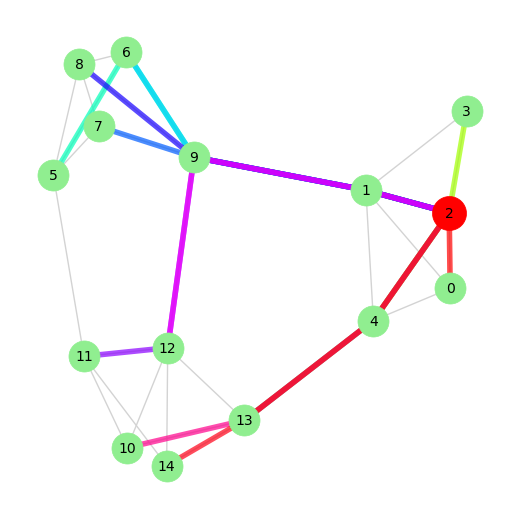

In [6]:
colors = plt.cm.get_cmap('hsv', len(shortest_paths_from_2))
pos = nx.spring_layout(g1)  # Layout for the graph
plt.figure(figsize=(5, 5))
nx.draw(g1, pos, node_color='lightgreen', with_labels=True, node_size=500, font_size=10, edge_color='lightgray')
    
# Iterate through all shortest paths from the source node
for idx, (target, path) in enumerate(shortest_paths_from_2.items()):
    # Convert the path into a list of edges
    edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        
    # Draw the path with a bold line and a distinct color
    nx.draw_networkx_edges(g1, pos, edgelist=edges_in_path, width=4, edge_color=[colors(idx)], alpha=0.7)

# Highlight the source node in red
nx.draw_networkx_nodes(g1, pos, nodelist=[2], node_color='red', node_size=600)
plt.show()

## Question 2

Now, calculate the shortest paths between all pairs of nodes within the network. *Hint: use a nested loop to iterate through pairs of nodes.*

In [7]:
nodes = list(g1.nodes)
all_shortest_paths = {}

# Loop through all pairs of nodes
for node1 in nodes:
    all_shortest_paths[node1] = {}
    for node2 in nodes:
        if node1 != node2:
            path = nx.shortest_path(g1, source=node1, target=node2)
            all_shortest_paths[node1][node2] = path
        else:
        # Path to self is the node itself
            all_shortest_paths[node1][node2] = [node1]

            all_shortest_paths 

In [8]:
grader.check("q2")

q2 results: All test cases passed!

Alternatively, you can use the method all_pairs_shortest_path(G) to return shortest paths between all pairs of nodes in a network without using loops:

In [9]:
dict(nx.all_pairs_shortest_path(g1))

{0: {0: [0],
  1: [0, 1],
  2: [0, 2],
  4: [0, 4],
  3: [0, 1, 3],
  9: [0, 1, 9],
  13: [0, 4, 13],
  6: [0, 1, 9, 6],
  7: [0, 1, 9, 7],
  8: [0, 1, 9, 8],
  12: [0, 1, 9, 12],
  10: [0, 4, 13, 10],
  14: [0, 4, 13, 14],
  5: [0, 1, 9, 6, 5],
  11: [0, 1, 9, 12, 11]},
 1: {1: [1],
  0: [1, 0],
  2: [1, 2],
  3: [1, 3],
  4: [1, 4],
  9: [1, 9],
  13: [1, 4, 13],
  6: [1, 9, 6],
  7: [1, 9, 7],
  8: [1, 9, 8],
  12: [1, 9, 12],
  10: [1, 4, 13, 10],
  14: [1, 4, 13, 14],
  5: [1, 9, 6, 5],
  11: [1, 9, 12, 11]},
 2: {2: [2],
  0: [2, 0],
  1: [2, 1],
  3: [2, 3],
  4: [2, 4],
  9: [2, 1, 9],
  13: [2, 4, 13],
  6: [2, 1, 9, 6],
  7: [2, 1, 9, 7],
  8: [2, 1, 9, 8],
  12: [2, 1, 9, 12],
  10: [2, 4, 13, 10],
  14: [2, 4, 13, 14],
  5: [2, 1, 9, 6, 5],
  11: [2, 1, 9, 12, 11]},
 4: {4: [4],
  0: [4, 0],
  1: [4, 1],
  2: [4, 2],
  13: [4, 13],
  3: [4, 1, 3],
  9: [4, 1, 9],
  10: [4, 13, 10],
  12: [4, 13, 12],
  14: [4, 13, 14],
  6: [4, 1, 9, 6],
  7: [4, 1, 9, 7],
  8: [4, 1, 9, 8]

Next, we need to figure out how many shortest paths pass through a specific edge. Let's use the edge (1,9) as an example:

In [10]:
paths_thru_1_9 = []
edge = (1,9)

# Iterate over all paths 
for source in all_shortest_paths:
    for target, path in all_shortest_paths[source].items():
        # check if nodes 1 and 9 appear in path
        if edge[0] in path and edge[1] in path:
            # Ensure nodes 1 and 9 appear next to each other in path
            for i in range(len(path) - 1):
                if (path[i], path[i + 1]) == edge or (path[i + 1], path[i]) == edge:
                    paths_thru_1_9.append(path)
                    break
    
paths_thru_1_9

[[0, 1, 9],
 [0, 1, 9, 6, 5],
 [0, 1, 9, 6],
 [0, 1, 9, 7],
 [0, 1, 9, 8],
 [0, 1, 9, 12, 11],
 [0, 1, 9, 12],
 [1, 9],
 [1, 9, 6, 5],
 [1, 9, 6],
 [1, 9, 7],
 [1, 9, 8],
 [1, 9, 12, 11],
 [1, 9, 12],
 [1, 9, 12, 10],
 [1, 9, 12, 14],
 [2, 1, 9],
 [2, 1, 9, 6, 5],
 [2, 1, 9, 6],
 [2, 1, 9, 7],
 [2, 1, 9, 8],
 [2, 1, 9, 12, 11],
 [2, 1, 9, 12],
 [4, 1, 9],
 [4, 1, 9, 6, 5],
 [4, 1, 9, 6],
 [4, 1, 9, 7],
 [4, 1, 9, 8],
 [3, 1, 9],
 [3, 1, 9, 6, 5],
 [3, 1, 9, 6],
 [3, 1, 9, 7],
 [3, 1, 9, 8],
 [3, 1, 9, 12, 11],
 [3, 1, 9, 12],
 [9, 1, 0],
 [9, 1],
 [9, 1, 2],
 [9, 1, 4],
 [9, 1, 3],
 [5, 6, 9, 1, 0],
 [5, 6, 9, 1],
 [5, 6, 9, 1, 2],
 [5, 6, 9, 1, 4],
 [5, 6, 9, 1, 3],
 [6, 9, 1, 0],
 [6, 9, 1],
 [6, 9, 1, 2],
 [6, 9, 1, 4],
 [6, 9, 1, 3],
 [7, 9, 1, 0],
 [7, 9, 1],
 [7, 9, 1, 2],
 [7, 9, 1, 4],
 [7, 9, 1, 3],
 [8, 9, 1, 0],
 [8, 9, 1],
 [8, 9, 1, 2],
 [8, 9, 1, 4],
 [8, 9, 1, 3],
 [11, 12, 9, 1, 0],
 [11, 12, 9, 1],
 [11, 12, 9, 1, 2],
 [11, 12, 9, 1, 3],
 [12, 9, 1, 0],
 [12, 9, 1],
 [

## Question 3

Now, we can calculate the betweenness centrality of edge (1,9):

In [11]:
count_all_shortest_paths = sum(len(paths) for paths in all_shortest_paths.values())
count_all_paths_1_9 = len(paths_thru_1_9)

ebc_1_9 = count_all_paths_1_9/count_all_shortest_paths

ebc_1_9

0.32

In [12]:
grader.check("q3")

q3 results: All test cases passed!

Conveniently, you can use the networkx method edge_betweenness_centrality( ) to calculate the edge betweenness centrality for all edges in a network:

In [13]:
edge_betweenness = nx.edge_betweenness_centrality(g1)
# check edge betweenness centrality of the edge (1,9)
edge_betweenness[(1,9)]

0.3015873015873016

Note that the result is slightly different - this is because we used a simplified algorithm to illustrate the steps of calculating edge betweenness centrality. If you are interested, you can check how networkx implements it in its [documentation](https://networkx.org/documentation/stable/_modules/networkx/algorithms/centrality/betweenness.html#edge_betweenness_centrality). 

## The Girvan-Newman Method of Community Detection 

The Girvan-Newman algorithm involves the following steps：

1. Calculate betweenness centrality for all edges in the network.

2. Remove the edge with the highest value of betweenness centrality (i.e., the most 'bridging' edge).

3. Recalculate betweenness centrality for all edges in the network.
4. Repeat steps 2 and 3 until certain conditions are reached (e.g. when the network has been split into n communities) 

## Question 4

Let's first try the Girvan-Newman method manually on our example network. Step 1 is already done above. Do steps 2 and 3: find the edge with the highest betweenness centrality and remove it from the network. 

In [14]:
# make a copy of g1
g1_copy = g1
edge_betweenness = nx.edge_betweenness_centrality(g1_copy)
#edge_betweenness

max_key = None
max_value = 0

for key, value in edge_betweenness.items():
    if value > max_value:
        max_value = value
        max_key = key

edge_to_remove = max_key

# Remove the edge from the graph
g1_copy.remove_edge(*edge_to_remove)

edge_to_remove

(1, 9)

In [15]:
grader.check("q4")

q4 results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5

Plot the network after removing one edge: 

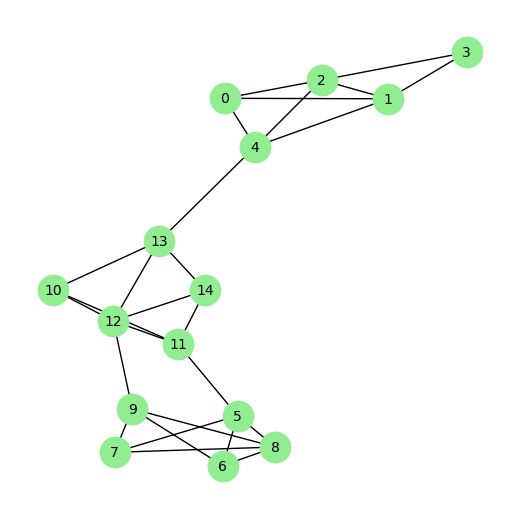

In [16]:
plt.figure(figsize=(5, 5))
nx.draw(g1_copy, with_labels=True, node_color='lightgreen', edge_color='black', node_size=500, font_size=10)
plt.show()

<!-- END QUESTION -->

Let's repeat step 2 and 3 again:

In [17]:
edge_betweenness_r2 = nx.edge_betweenness_centrality(g1_copy)

edge_to_remove_r2 = max(edge_betweenness_r2, key=edge_betweenness_r2.get)
# Remove the edge from the graph
g1_copy.remove_edge(*edge_to_remove_r2)

edge_to_remove_r2

(4, 13)

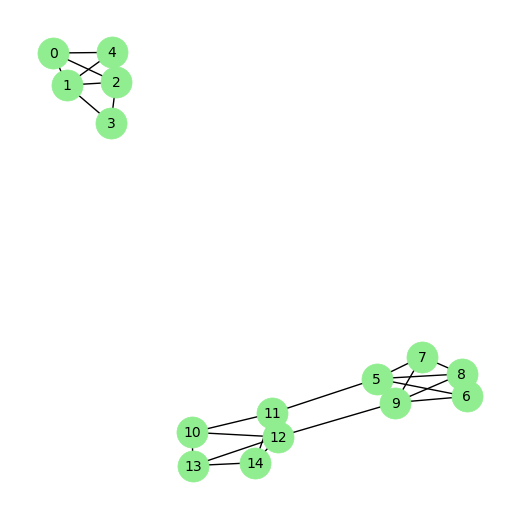

In [18]:
plt.figure(figsize=(5, 5))
nx.draw(g1_copy, with_labels=True, node_color='lightgreen', edge_color='black', node_size=500, font_size=10)
plt.show()

After two repetitions, the network is split into two cliques. In other words, two communities have been detected by our algorithm. We can stop here, or continue until more communities are detected. 

There is also a girvan_newman( ) method in networkx. We can run it until all nodes are their own community:

In [19]:
communities = nx.community.girvan_newman(g1)

level = 0
for c in communities:
    level += 1
    print(f"Level {level} Communities: {[sorted(list(i)) for i in c]}")

Level 1 Communities: [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14]]
Level 2 Communities: [[0, 1, 2, 4], [3], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14]]
Level 3 Communities: [[0, 1, 2, 4], [3], [9], [10, 11, 12, 13, 14], [5, 6, 7, 8]]
Level 4 Communities: [[0, 1, 2, 4], [3], [9], [13], [5, 6, 7, 8], [10, 11, 12, 14]]
Level 5 Communities: [[0, 1, 2, 4], [3], [9], [13], [5, 7, 8], [6], [10, 11, 12, 14]]
Level 6 Communities: [[0, 1, 2, 4], [3], [9], [13], [5, 7, 8], [6], [11, 12, 14], [10]]
Level 7 Communities: [[0], [1, 2, 4], [3], [9], [13], [5, 7, 8], [6], [11, 12, 14], [10]]
Level 8 Communities: [[0], [1], [2, 4], [3], [9], [13], [5, 7, 8], [6], [11, 12, 14], [10]]
Level 9 Communities: [[0], [1], [2], [4], [3], [9], [13], [5, 7, 8], [6], [11, 12, 14], [10]]
Level 10 Communities: [[0], [1], [2], [4], [3], [9], [13], [5], [6], [7, 8], [11, 12, 14], [10]]
Level 11 Communities: [[0], [1], [2], [4], [3], [9], [13], [5], [6], [7], [8], [11, 12, 14], [10]]
Level 12 Communities: [[0], [1

## Modularity

Modularity is a measure of the strength of division of a network into communities. It compares the fraction of ends of edges ('stubs') in the network connecting nodes within the same community to the same fraction in a randomly generated network.

$$Q = \sum _i (e_{ii} - a^{2}_{i})$$

where $e_{ii}$ is the fraction of stubs connecting nodes in community $i$ to other nodes in community $i$ in the target network, 

and $a^{2}_{i}$ is the fraction of stubs connecting nodes in community $i$ to other nodes in community $i$ in a random network, serving as the null model.

Let's calculate modularities for each level of communities we found using the Girvan-Norman algorithm above: 


In [20]:
communities = nx.community.girvan_newman(g1)
modularity_values = []

level = 0
for c in communities:
    level += 1
    # Calculate modularity
    modularity_value = nx.community.modularity(g1, [list(i) for i in c])
    modularity_values.append((level, modularity_value))

modularity_values

[(1, 0.5887573964497042),
 (2, 0.5325443786982249),
 (3, 0.45857988165680474),
 (4, 0.37647928994082847),
 (5, 0.32396449704142016),
 (6, 0.2736686390532545),
 (7, 0.18269230769230774),
 (8, 0.1264792899408284),
 (9, 0.09689349112426038),
 (10, 0.040680473372781065),
 (11, 0.011094674556213015),
 (12, -0.042159763313609475),
 (13, -0.06952662721893493)]

<!-- BEGIN QUESTION -->

## Question 6

Which level of communities has the highest modularity? What does it say about the quality of our community detection at that level?

<!-- END QUESTION -->

## Indian Village Network Data

This is a dataset collected by [Banerjee et al.](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/U3BIHX) (2013) in 43 villages in South India to study the diffusion of microfinance. The edges in the networks are defined by different relationships.

The possible relationships are:

Individuals were asked who they:   
-- borrow money from   
-- give advice to  
-- help with a decision  
-- borrow kerosene or rice from   
-- lend kerosene or rice to   
-- lend money to  
-- obtain medical advice from   
-- engage socially with  
-- are related to  
-- go to temple with  
-- invite to one's home  
-- visit in another's home.  

and the codename for the relationships:

adj_borrowmoney_HH_vilno_##   
adj_giveadvice_HH_vilno_##   
adj_helpdecision_HH_vilno_##  
adj_keroricecome_HH_vilno_##   
adj_keroricego_HH_vilno_##   
adj_lendmoney_HH_vilno_##   
adj_medic_HH_vilno_##   
adj_nonrel_HH_vilno_##   
adj_rel_HH_vilno_##   
adj_templecompany_HH_vilno_##   
adj_visitcome_HH_vilno_##   
adj_visitgo_HH_vilno_##   
adj_allVillageRelationships_HH_vilno_##   
adj_andRelationships_HH_vilno_##   

In [21]:
all_relations = ['borrowmoney',
                 'giveadvice',
                 'helpdecision',
                 'keroricecome',
                 'keroricego',
                 'lendmoney',
                 'medic',
                 'nonrel',
                 'rel',
                 'templecompany',
                 'visitcome',
                 'visitgo',
                 'allVillageRelationships',
                 'andRelationships']

In [22]:
data_path = "data/"

Create functions to read in all edges at individual and household levels:

In [23]:
def read_village_edges(village_id, relationship='borrowmoney', data_path=data_path):
    """
    village_id : integer from 1 to 77 
    
    read in the village network corresponding to the given id number and
    return it as an undirected networkx object
    
    note that this reads the individual network ties (not the household level ones)
    
    not all individuals were surveyed, so some nodes have attributes filled in
    and some do not
    """

    adj_path = os.path.join(data_path, '1. Network Data', 'Adjacency Matrices')
    id_path = os.path.join(data_path, '1. Network Data', 'Adjacency Matrix Keys')
   

    # this file has the adjacency matrix
    edge_file = os.path.join(adj_path, "adj_" + str(relationship) + "_vilno_" + str(village_id) + ".csv")
    # this has the study id number corresponding to the rows/columns of the adjacency matrix
    id_file = os.path.join(id_path, "key_vilno_" + str(village_id) + ".csv")
    
    # read data with characteristics of individuals
    ind_char_data_path = os.path.join(data_path, 
                                      '2. Demographics and Outcomes', 
                                      'individual_characteristics.dta')
    
    adj_mat = pd.read_csv(edge_file, sep=',', header=None)
    network = nx.from_pandas_adjacency(adj_mat)

    # add the study ids as node attributes
    with open(id_file, 'r') as f:
        id_keys = f.readlines()
        
    id_dict = dict([(cur_index, cur_id.strip()) for cur_index, cur_id in enumerate(id_keys)])
    inv_id_dict = {v: k for k,v in id_dict.items()}

    node_characteristics = pd.read_stata(ind_char_data_path)
    
    # make this list of dicts into a dictionary whose keys are the pids and whose entries 
    # are dictionaries with the rest of the attributes
    attr_dict = {}
    for item in node_characteristics.to_dict(orient='records'):
        cur_pid = item['pid']
        if(str(cur_pid) in inv_id_dict.keys()):
            attr_dict[inv_id_dict[str(cur_pid)]] = item

    nx.set_node_attributes(network,
                           values = attr_dict)
    
    # note that we call the to_undirected method to ensure we get an undirected network
    return(network.to_undirected())

def read_village_hh_edges(village_id, relationship='borrowmoney', data_path=data_path):
    """
    village_id : integer from 1 to 77
    
    read in the village household network corresponding to the given id number and
    return it as an undirected networkx object
    
    note that this reads the household network ties (not the individual level ones)    
    """

    adj_path = os.path.join(data_path, '1. Network Data', 'Adjacency Matrices')
    id_path = os.path.join(data_path, '1. Network Data', 'Adjacency Matrix Keys')
   

    # this file has the adjacency matrix
    edge_file = os.path.join(adj_path, "adj_" + str(relationship) + "_vilno_" + str(village_id) + ".csv")
    # this has the study id number corresponding to the rows/columns of the adjacency matrix
    id_file = os.path.join(id_path, "key_HH_vilno_" + str(village_id) + ".csv")
    
    # read data with characteristics of individuals
    hh_char_data_path = os.path.join(data_path, 
                                      '2. Demographics and Outcomes', 
                                      'household_characteristics.dta')
    
    adj_mat = pd.read_csv(edge_file, sep=',', header=None)
    network = nx.from_pandas_adjacency(adj_mat)

    # add the study ids as node attributes
    with open(id_file, 'r') as f:
        id_keys = f.readlines()
        
    id_dict = dict([(cur_index, 
                     str(village_id) + cur_id.strip().zfill(3)) for cur_index, cur_id in enumerate(id_keys)])
    inv_id_dict = {v: k for k,v in id_dict.items()}

    node_characteristics = pd.read_stata(hh_char_data_path)
    
    # make this list of dicts into a dictionary whose keys are the pids and whose entries 
    # are dictionaries with the rest of the attributes
    attr_dict = {}
 
    for item in node_characteristics.to_dict(orient='records'):
        cur_hhid = item['hhid']
        if(str(cur_hhid) in inv_id_dict.keys()):
            attr_dict[inv_id_dict[str(cur_hhid)]] = item
 
    #import pdb; pdb.set_trace()        
 
            
    nx.set_node_attributes(network,
                           values = attr_dict)
    
    # note that we call the to_undirected method to ensure we get an undirected network
    return(network.to_undirected())

Let's read in the network of village #3

In [24]:
g_village = read_village_hh_edges(3, data_path = data_path)

And examine the network defined by which relationship is the most dense (i.e., has the highest average degree)

In [25]:
def net_avg_degree(g):
    return np.mean([v for k,v in nx.average_degree_connectivity(g).items()])

In [26]:
cur_nets = {}
cur_village = 3

for cur_relation in all_relations:
    cur_nets[cur_relation] = read_village_hh_edges(cur_village, relationship=cur_relation, data_path=data_path)

avg_degrees = {vid: net_avg_degree(cur_v_g) for vid, cur_v_g in cur_nets.items()}
avg_degrees

{'borrowmoney': 6.307737949056782,
 'giveadvice': 5.8513400682802468,
 'helpdecision': 6.2294802143846768,
 'keroricecome': 6.8162453613470788,
 'keroricego': 6.5563803098658369,
 'lendmoney': 6.1185447936542321,
 'medic': 5.8564913372952434,
 'nonrel': 6.877390720507095,
 'rel': 6.8097010334134565,
 'templecompany': 5.504063279307279,
 'visitcome': 6.3752617148130497,
 'visitgo': 6.5181576311098386,
 'allVillageRelationships': 11.576710591280861,
 'andRelationships': 5.5}

It looks like, among all relationships, the highest degree is in `nonrel`, which appears to be the 'engage socially with' tie. Let's select the `nonrel` network and plot it.

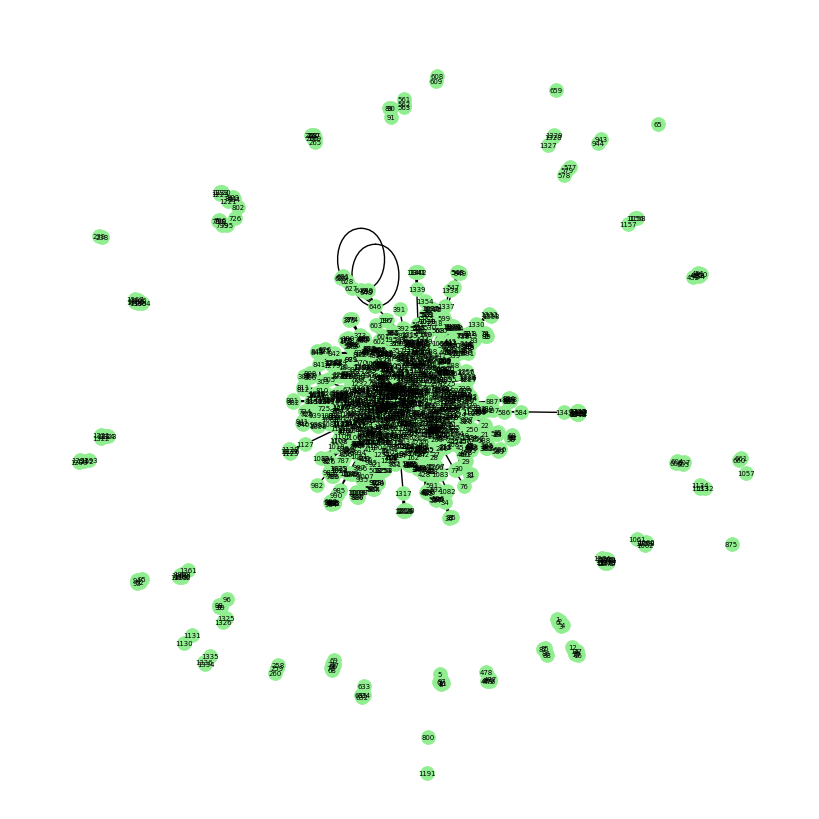

In [27]:
cur_net = cur_nets['nonrel']
plt.figure(figsize=(8, 8))
nx.draw(cur_net, with_labels=True, node_color='lightgreen', edge_color='black', node_size=100, font_size=5)
plt.show()

It seems that there is a giant component in this network. Let's write a function to select the largest component subgraph:

In [28]:
def get_largest_component_subgraph(net):
    largest_cc = max(nx.connected_components(net), key=len)
    largest_cc_graph = net.subgraph(largest_cc).copy()
    return largest_cc_graph

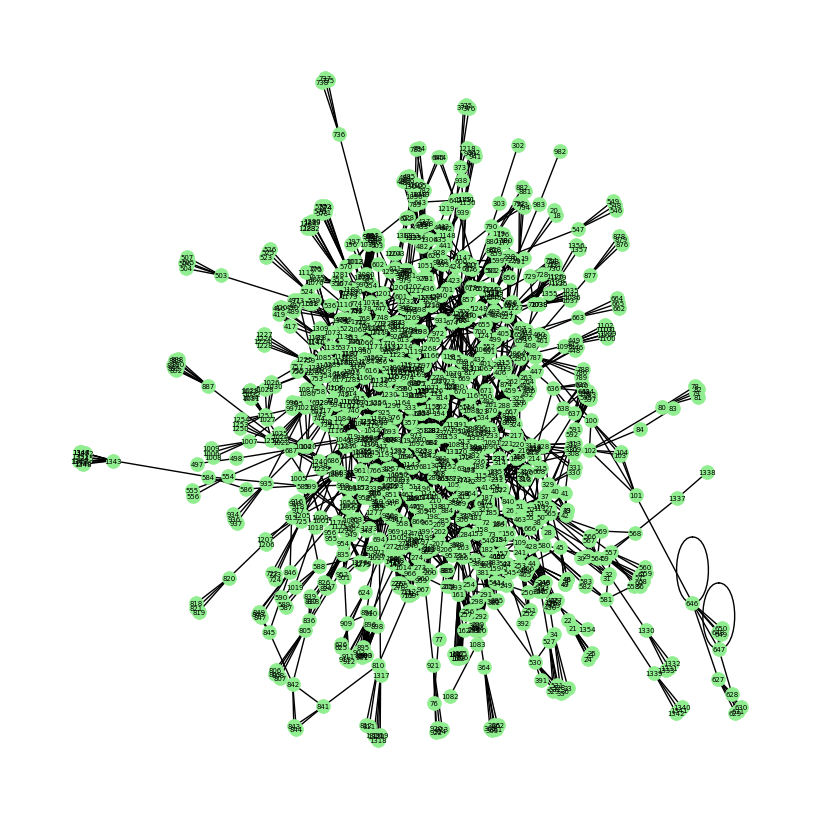

In [29]:
cur_net_gcc = get_largest_component_subgraph(cur_net)
plt.figure(figsize=(8, 8))
nx.draw(cur_net_gcc, with_labels=True, node_color='lightgreen', edge_color='black', node_size=100, font_size=5)
plt.show()

## Question 7

Use the Girvan-Newman algorithm (the networkx method) we learned above, partition this network into communities. Stop at level 3. (it should take a few minutes to finish running): 

In [30]:
communities_village = nx.community.girvan_newman(cur_net_gcc)
community_list = []
modularity_values = []

level = 0
for c in communities_village:
    level += 1
    if level > 3:
        break
    community_list.append([sorted(list(i)) for i in c])
    modularity_value = nx.community.modularity(cur_net_gcc, [list(i) for i in c])
    modularity_values.append((level, modularity_value))

community_list[2][3]

#communities = nx.community.girvan_newman(cur_net_gcc)

#level = 0
#for c in communities:
#    level += 1
#    while level < 3:
#        print(f"Level {level} Communities: {[sorted(list(i)) for i in c]}")

[584, 586, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352]

In [31]:
grader.check("q7")

q7 results: All test cases passed!

Now, we will use the [functions](https://networkx.org/documentation/stable/auto_examples/algorithms/plot_girvan_newman.html) provided in networx documentation to plot communities in different colors:

In [32]:
# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities)
    colors = [
  '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728',
  '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
  '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#393b79',
  '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252', '#b5cf6b', '#cedb9c',
  '#8c6d31', '#bd9e39', '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b',
  '#e7969c', '#7b4173', '#a55194', '#ce6dbd', '#de9ed6', '#3182bd', '#6baed6',
  '#9ecae1', '#c6dbef'
][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.kamada_kawai_layout(graph)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=100,
        node_color=node_colors,
        with_labels=True,
        font_size=5,
        width = 0.1,
        font_color="black",
    )

Let's visualize level 3, the level with the highest modularity:

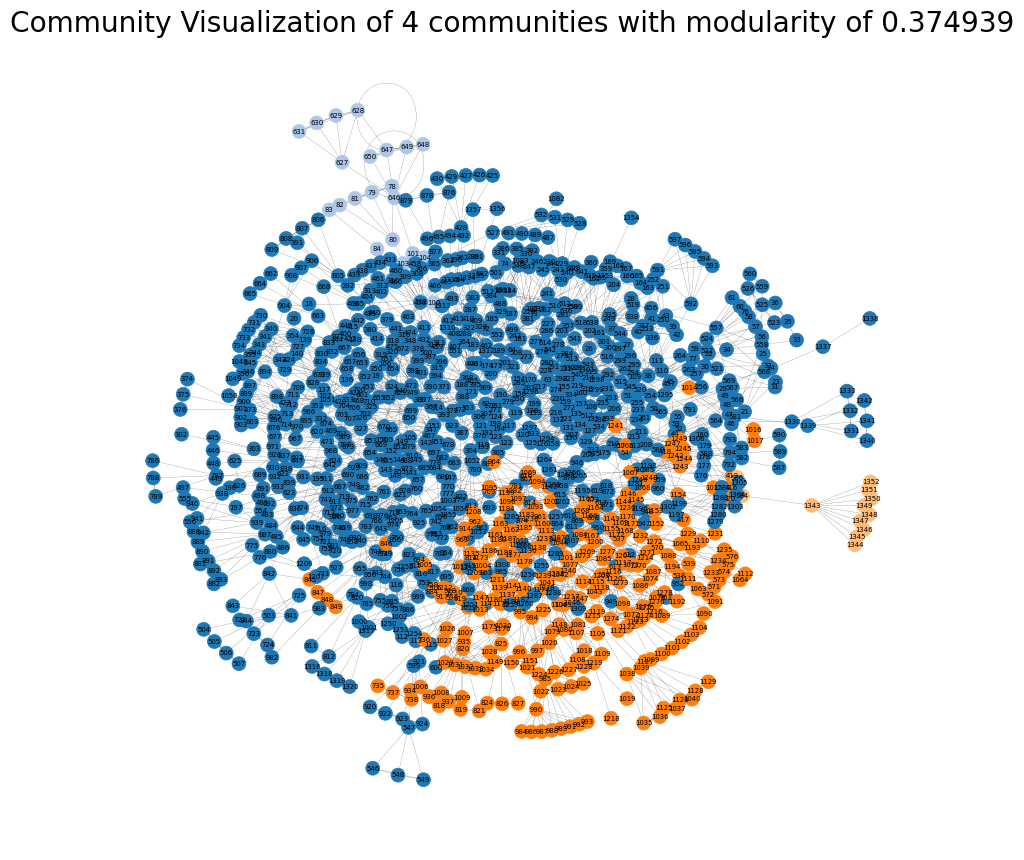

In [33]:
visualize_communities(cur_net_gcc, community_list[2])

Besides the Girvan-Newman algorithm we have used so far, there are also many other community detection algorithms. You can find a [list](https://networkx.org/documentation/stable/reference/algorithms/community.html) of networkx methods corresponding to different algorithms. Let's apply an agglomerative algorithm called [Greedy Modularity](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities), which "begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no further increase in modularity is possible." 

In [34]:
communities_greedy = nx.community.greedy_modularity_communities(cur_net_gcc)

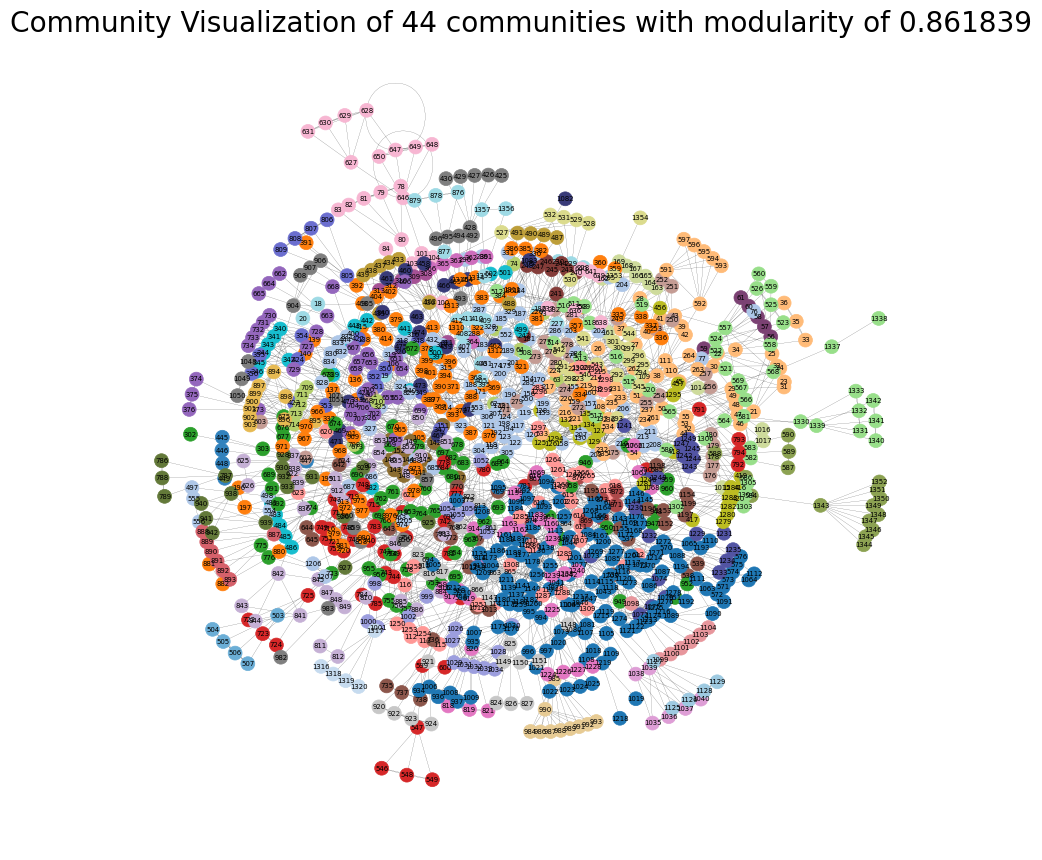

In [35]:
visualize_communities(cur_net_gcc, communities_greedy)

This algorithm detects 44 communities with a modularity of 0.86, which is substantially higher than 0.37 at level 3 of the Girvan-Norman algorithm. It is possible that if we run the Girvan-Norman algorithm to deeper levels, we can eventually reach a similar modularity, but it would be computationally and temporally expensive. However, this might not be the case if we run them on a different network. On the other hand, it might be much more difficult to interpret a 44-community network than a 4-community network.  

There is no universally best community detection algorithm, one can try different algorithms, compare the results, and select the one(s) that fit(s) the dataset and the reseach question.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [36]:
grader.check_all()

q2 results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

q7 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please upload the .zip file to Gradescope.

In [37]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4 results: All test cases passed!

    q7 results: All test cases passed!
